# Deep learning

label     int64
text     object
dtype: object (34152, 2)


,label,text
0,0,donald trump sends out embarrassing new year‚s...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes an internet joke ...
3,0,trump is so obsessed he even has obama‚s name ...
4,0,pope francis just called out donald trump duri...


label    0
text     0
dtype: int64
Unique label values: [0 1]
Empty texts: 0
Duplicated entries: 1946


(32206, 2)

label
1    16181
0    16025
Name: count, dtype: int64


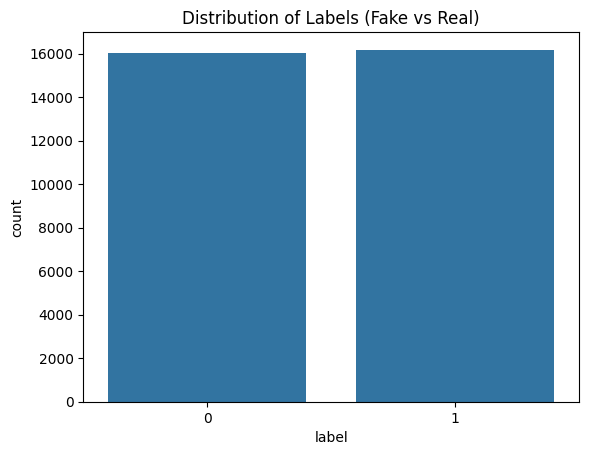

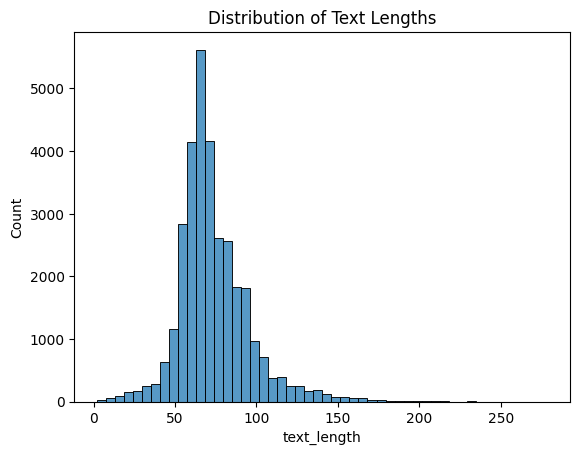

In [1]:
# import and run all cells of the preprocessing file

import nbformat
from IPython.core.interactiveshell import InteractiveShell

with open('preprocessing.ipynb') as f:
    nb = nbformat.read(f, as_version=4)

shell = InteractiveShell.instance()
for cell in nb.cells:
    if cell.cell_type == 'code':
        shell.run_cell(cell.source)

## Create Tokenizer

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# also preprocess test data
X_test = X_test.apply(text_preprocessing_pipeline)

max_words = 10000

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Calculate the longest sequence 
max_len_sequence_train = max(len(seq) for seq in X_train_seq)
max_len_sequence_test = max(len(seq) for seq in X_test_seq)
max_len = max_len_sequence_train if max_len_sequence_train > max_len_sequence_test else max_len_sequence_test

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

## Basic Model (Learned Embedding)
Define and train a Bidirectional LSTM model with embedding, using early stopping to prevent overfitting, then evaluate on test data.

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

embedding_dim = 50

basic_model = Sequential([
    Embedding(max_words, output_dim=embedding_dim, input_length=max_len),
    Bidirectional(LSTM(150, return_sequences=True)),
    Dropout(0.2),
    LSTM(100),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

basic_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = basic_model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop]
)

loss, accuracy = basic_model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/10


/Users/benpaffrath/.pyenv/versions/3.12.10/envs/ironhack/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


363/363 ━━━━━━━━━━━━━━━━━━━━ 38s 98ms/step - accuracy: 0.7889 - loss: 0.7951 - val_accuracy: 0.9383 - val_loss: 0.1738
Epoch 2/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 41s 112ms/step - accuracy: 0.9720 - loss: 0.0946 - val_accuracy: 0.9468 - val_loss: 0.1488
Epoch 3/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 38s 105ms/step - accuracy: 0.9817 - loss: 0.0626 - val_accuracy: 0.9418 - val_loss: 0.1754
Epoch 4/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 41s 113ms/step - accuracy: 0.9869 - loss: 0.0509 - val_accuracy: 0.9418 - val_loss: 0.2484
Epoch 5/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 45s 124ms/step - accuracy: 0.9901 - loss: 0.0391 - val_accuracy: 0.9379 - val_loss: 0.2374
202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.9511 - loss: 0.1403
Test Accuracy: 0.9492


In [27]:
from sklearn.metrics import classification_report

y_pred_proba = basic_model.predict(X_test_pad)
y_pred = (y_pred_proba > 0.5).astype(int)

print(classification_report(y_test, y_pred, digits=3))

202/202 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step
              precision    recall  f1-score   support

           0      0.949     0.948     0.948      3159
           1      0.950     0.951     0.950      3283

    accuracy                          0.949      6442
   macro avg      0.949     0.949     0.949      6442
weighted avg      0.949     0.949     0.949      6442



202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step


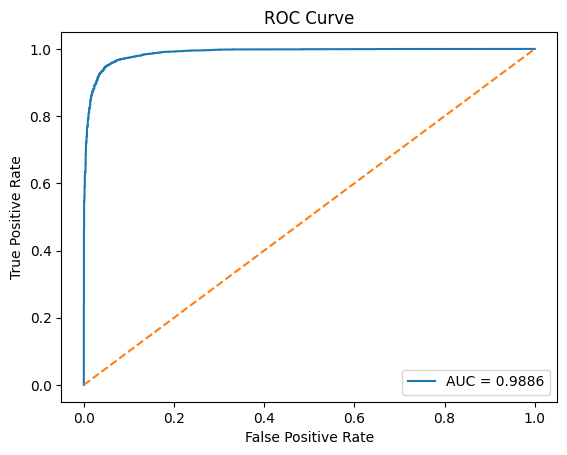

In [ ]:
# Plot ROC curve and calculate AUC to evaluate model's binary classification performance.

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob = basic_model.predict(X_test_pad).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


## Model with GloVe Pre-trained embedding

In [7]:
import numpy as np

embedding_dim = 50  # must match the GloVe file
glove_path = "../glove/glove.6B.50d.txt"

embeddings_index = {}

# Load the GloVe embeddings file and create a dictionary mapping words to their embedding vectors
with open(glove_path, encoding="utf8") as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

# Initialize an embedding matrix of zeros with shape (max_words, embedding_dim) 
embedding_matrix = np.zeros((max_words, embedding_dim))

# For each word within the max_words limit, check if a GloVe vector exists
# If it does, assign the vector to the corresponding row in the embedding matrix
for word, i in tokenizer.word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector   


glove_model = Sequential([
    Embedding(input_dim=max_words,
              output_dim=embedding_dim,
              input_length=max_len,
              weights=[embedding_matrix],
              trainable=False),  # freeze GloVe
    Bidirectional(LSTM(150, return_sequences=True)),
    Dropout(0.2),
    LSTM(100),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2()),
    Dense(1, activation='sigmoid')
])

glove_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = glove_model.fit(
    X_train_pad, y_train,
    epochs=3,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop]
)

loss, accuracy = glove_model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


Epoch 1/3


/Users/benpaffrath/.pyenv/versions/3.12.10/envs/ironhack/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


363/363 ━━━━━━━━━━━━━━━━━━━━ 49s 130ms/step - accuracy: 0.8322 - loss: 0.7904 - val_accuracy: 0.8976 - val_loss: 0.2427
Epoch 2/3
363/363 ━━━━━━━━━━━━━━━━━━━━ 46s 128ms/step - accuracy: 0.9085 - loss: 0.2294 - val_accuracy: 0.9170 - val_loss: 0.2090
Epoch 3/3
363/363 ━━━━━━━━━━━━━━━━━━━━ 49s 136ms/step - accuracy: 0.9211 - loss: 0.1954 - val_accuracy: 0.9123 - val_loss: 0.2167
202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9144 - loss: 0.2113
Test Accuracy: 0.9190


In [26]:
from sklearn.metrics import classification_report

y_pred_proba = glove_model.predict(X_test_pad)
y_pred = (y_pred_proba > 0.5).astype(int)

print(classification_report(y_test, y_pred, digits=3))


202/202 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step
              precision    recall  f1-score   support

           0      0.942     0.890     0.915      3159
           1      0.899     0.947     0.923      3283

    accuracy                          0.919      6442
   macro avg      0.921     0.918     0.919      6442
weighted avg      0.920     0.919     0.919      6442



## Predictions

In [ ]:
from sklearn.metrics import accuracy_score


test_data = pd.read_csv("../dataset/testing_data_lowercase_nolabels.csv", usecols=[1], header=None, names=["text"], sep="	")

#Apply the same text preprocessing pipeline used during training
test_data["text"] = test_data["text"].apply(text_preprocessing_pipeline)

# Convert the text to sequences using the same tokenizer as used in training
sequences = tokenizer.texts_to_sequences(test_data["text"])
padded_sequences = pad_sequences(sequences, maxlen=max_len)

predictions_basic_model = basic_model.predict(padded_sequences)
predictions_glove_model = glove_model.predict(padded_sequences)

# Convert probabilities to binary labels
predicted_labels_basic_model = (predictions_basic_model > 0.5).astype(int)
predicted_labels_glove_model = (predictions_glove_model > 0.5).astype(int)

# Count the occurrences of each predicted label
unique_b, counts_b = np.unique(predicted_labels_basic_model, return_counts=True)
unique_g, counts_g = np.unique(predicted_labels_glove_model, return_counts=True)

train_predictions = basic_model.predict(X_train_pad)
train_predicted_labels = (train_predictions > 0.5).astype(int)
train_accuracy = accuracy_score(y_train, train_predicted_labels)
print(f"Train Accuracy: {train_accuracy:.4f}")

print("Prediction Basic Model:", unique_b, counts_b)
print("Prediction Glove Model:", unique_g, counts_g)

312/312 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
312/312 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
806/806 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step
Train Accuracy: 0.9820
Prediction Basic Model: [0 1] [7359 2625]
Prediction Glove Model: [0] [9984]


## Save predictions to file

In [57]:
# Load test data, combine predictions with text, and save to a TSV file without headers or index
test_data = pd.read_csv("../dataset/testing_data_lowercase_nolabels.csv", usecols=[1], header=None, names=["text"], sep="	")

labels_df = pd.DataFrame(predicted_labels_basic_model, columns=[0])
text_df = test_data[["text"]]

output_df = pd.concat([labels_df, text_df], axis=1)

output_df.to_csv("../predictions/G5-embeddings-predictions.csv", index=False, header=None, sep="	")